* In this assignment you will be implementing an encoder model that uses just **Masked Language Modelling (MLM)** objective.
* We will use a simple BERT with the following modifications
  * We just use MLM (just masking words) and **skip** NSP (Next Sentence Prediction) objective
  * Therefore, we won't use [CLS] token
* Again, it is absolutely fine if your loss value does not match with the one given here.
* Just ensure that the model overfits the training data
* You may increase the size of the training data if you want to test your implementation. In that case, we recommend you to use the tokenizer library from Hugging face



# Installations

In [ ]:
!pip install torchdata==0.6.0 # to be compatible with torch 2.0
!pip install portalocker==2.0.0
!pip install -U torchtext==0.15.1

# Common Imports

In [ ]:
import torch
from torch import Tensor
import math
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.nn.functional import one_hot

import torch.optim as optim

#text lib
import torchtext

# tokenizer
from torchtext.data.utils import get_tokenizer

#build vocabulary
from torchtext.vocab import vocab
from torchtext.vocab import build_vocab_from_iterator

# get input_ids (numericalization)
from torchtext.transforms import VocabTransform

# get embeddings
from torch.nn import Embedding

from  pprint import pprint
from yaml import safe_load
import copy
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Tokenize the given text

In [ ]:
batch_size = 10

In [ ]:
class Tokenizer(object):

  def __init__(self,text):
    self.text = text
    self.word_tokenizer = get_tokenizer(tokenizer="basic_english",language='en')
    self.vocab_size = None

  def get_tokens(self):
    for sentence in self.text.strip().split('\n'):
      yield self.word_tokenizer(sentence)

  def build_vocab(self):
    v = build_vocab_from_iterator(self.get_tokens(),
                                  min_freq=1,specials=['<unk>','<mask>'])
    v.set_default_index(v['<unk>']) # index of OOV
    self.vocab_size = len(v)
    return v

  def token_ids(self):
    v = self.build_vocab()
    vt = VocabTransform(v)
    num_tokens = len(self.word_tokenizer(self.text))
    max_seq_len = np.ceil(num_tokens/batch_size)
    data = torch.zeros(size=(1,num_tokens))
    data = vt(self.word_tokenizer(self.text))
    data = torch.tensor(data,dtype=torch.int64)
    return data.reshape(batch_size,torch.tensor(max_seq_len,dtype=torch.int64))



In [ ]:
text = """Best known for the invention of Error Correcting Codes, he was a true polymath who applied his mathematical and problem-solving skills to numerous disciplines.
Reflecting on the significant benefits I received from Hamming, I decided to develop a tribute to his legacy. There has not been a previous biography of Hamming, and the few articles about him restate known facts and assumptions and leave us with open questions.
One thought drove me as I developed this legacy project: An individual's legacy is more than a list of their attempts and accomplishments. Their tribute should also reveal the succeeding generations they inspired and enabled and what each attempted and achieved.
This book is a unique genre containing my version of a biography that intertwines the story "of a life" and a multi-player memoir with particular events and turning points recalled by those, including me, who he inspired and enabled.
Five years of research uncovered the people, places, opportunities, events, and influences that shaped Hamming. I discovered unpublished information, stories, photographs, videos, and personal remembrances to chronicle his life, which helped me put Hamming's
legacy in the context I wanted.The result demonstrates many exceptional qualities, including his noble pursuit of excellence and helping others. Hamming paid attention to the details, his writings continue to influence, and his guidance is a timeless gift to the world.
This biography is part of """

In [ ]:
Tk = Tokenizer(text)

In [ ]:
input_ids = Tk.token_ids()
print(input_ids.shape)

torch.Size([10, 26])


* We need to mask some words randomly based on the mask probability
* The token id for the [mask] is 1
* The function given below takes in the input ids and replaces some of the ids by 1 (token id for the [mask])
* Since the loss is computed only over the predictions of masked tokens, we replace all non-masked input ids by -100

In [ ]:
def getdata(ip_ids,mask_token_id,mask_prob=0.2):
  masked_ids = copy.deepcopy(ip_ids)
  mask_random_idx = torch.randn_like(ip_ids,dtype=torch.float64)>(1-mask_prob)
  masked_ids[mask_random_idx]=mask_token_id
  labels = copy.deepcopy(ip_ids)
  neg_mask = ~mask_random_idx
  labels[neg_mask]=torch.tensor(-100)
  return (masked_ids,labels,mask_random_idx)

In [ ]:
mask_token_id = torch.tensor([1],dtype=torch.int64)
x,y,mask_mtx = getdata(input_ids,mask_token_id)
print(x[0,:],'\n',y[0,:])

tensor([ 45,  23,  69,   5,  85,   7,  63,  53,  49,   2,   1, 148,   6, 139,
          1,  29,  36,   1,  89,   3,   1, 129,   8,  96,  59,   1]) 
 tensor([-100, -100, -100, -100, -100, -100, -100, -100, -100, -100,   20, -100,
        -100, -100,  110, -100, -100,    9, -100, -100,  112, -100, -100, -100,
        -100,    4])


* Now we have our inputs and labels stored in x and y,respectively
* It is always good to test the implementation by displaying the input sentence with masked tokens

In [ ]:
v = Tk.build_vocab()
words = []
for idx in x[0,:]:
  words.append(v.vocab.get_itos()[idx.item()])
print(' '.join(words))

best known for the invention of error correcting codes , <mask> was a true <mask> who applied <mask> mathematical and <mask> skills to numerous disciplines <mask>


* Also display the words that are masked

In [ ]:
words = []
for idx in y[0,:]:
  if idx != -100:
    words.append(v.vocab.get_itos()[idx.item()])
print(' '.join(words))

he polymath his problem-solving .


# Configuration

In [ ]:
vocab_size = Tk.vocab_size
seq_len = x.shape[1]
embed_dim = 32
dmodel = embed_dim
dq = torch.tensor(4)
dk = torch.tensor(4)
dv = torch.tensor(4)
heads = torch.tensor(8)
d_ff = 4*dmodel

# Model

In [ ]:
class MHA(nn.Module):

  def __init__(self, dmodel, dq, dk, dv,heads):
    super(MHA, self).__init__()
    self.d_model = dmodel
    self.heads = heads
    self.W_q = nn.Parameter(torch.randn((heads, dmodel, dq),generator = torch.manual_seed(43)))
    self.W_k = nn.Parameter(torch.randn((heads, dmodel, dk),generator = torch.manual_seed(44)))
    self.W_v = nn.Parameter(torch.randn((heads, dmodel, dv),generator = torch.manual_seed(45)))
    self.W_o = nn.Parameter(torch.randn((dmodel, dmodel),generator = torch.manual_seed(46)))

  def forward(self, Q, K, V):
    BS, T, _ = Q.shape
    Q = torch.einsum('BTM, HMQ -> BHTQ', Q, self.W_q)
    K = torch.einsum('BTM, HMK -> BHTK', K, self.W_k)
    V = torch.einsum('BTM, HMV -> BHTV', V, self.W_v)
    attn_score = torch.matmul(F.softmax((torch.matmul(Q,torch.transpose(K, -2, -1)))/math.sqrt(dq), dim = -1), V)
    combined_attn = attn_score.permute(0,2,1,3).contiguous().view(BS, T, -1)
    out = torch.matmul(combined_attn, self.W_o)
    return out


class FFN(nn.Module):

  def __init__(self, dmodel, d_ff):
    super(FFN, self).__init__()
    self.W1 = nn.Parameter(torch.randn((dmodel, d_ff), generator = torch.manual_seed(47)))
    self.b1 = nn.Parameter(torch.randn((d_ff), generator = torch.manual_seed(10)))
    self.W2 = nn.Parameter(torch.randn((d_ff, dmodel), generator = torch.manual_seed(48)))
    self.b2 = nn.Parameter(torch.randn((dmodel), generator = torch.manual_seed(10)))
    self.relu = nn.ReLU()

  def forward(self, x):
    out = torch.einsum('BTM, MH -> BTH', x, self.W1) + self.b1
    out = self.relu(out)
    out = torch.einsum('BTM, MH -> BTH', out, self.W2) + self.b2
    return out



class Prediction(nn.Module):

  def __init__(self, dmodel, trgt_vocab_size):
    super(Prediction, self).__init__()
    self.W = nn.Parameter(torch.randn((dmodel, trgt_vocab_size), generator = torch.manual_seed(49)))
    self.b = nn.Parameter(torch.randn((trgt_vocab_size), generator = torch.manual_seed(10)))

  def forward(self, x):
    out = torch.matmul(x, self.W) + self.b
    return out


class PositionalEncoding(nn.Module):

  def __init__(self,d_model, max_seq_len = 512):
      super(PositionalEncoding, self).__init__()
      pe = torch.zeros(max_seq_len, dmodel)
      position = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)
      div_term = torch.exp(torch.arange(0, dmodel, 2).float() * (-torch.log(torch.tensor(10000.0)) / dmodel))
      pe[:, 0::2] = torch.sin(position * div_term)
      pe[:, 1::2] = torch.cos(position * div_term)
      self.register_buffer('pe', pe.unsqueeze(0))

  def forward(self, x):
      x = x + self.pe[:, :x.size(1)]
      return x


class Embed(nn.Module):

  def __init__(self,vocab_size,embed_dim):
    super(Embed,self).__init__()
    self.embed_weights = nn.Embedding(num_embeddings = vocab_size, embedding_dim = dmodel, _weight = torch.randn((vocab_size, dmodel), generator=torch.manual_seed(70)))
    self.pe = PositionalEncoding(dmodel)

  def forward(self,x):
    '''
    Take in the input ids and output the final embeddings (token embedding + positional embedding)
    '''
    out = self.pe(self.embed_weights(x))
    return out


class EncoderLayer(nn.Module):

  def __init__(self,dmodel,dq,dk,dv,d_ff,heads):
    super(EncoderLayer,self).__init__()
    self.mha = MHA(dmodel,dq,dk,dv,heads)
    self.layer_norm_1 = torch.nn.LayerNorm(dmodel)
    self.layer_norm_2 = torch.nn.LayerNorm(dmodel)
    self.ffn = FFN(dmodel,d_ff)

  def forward(self,x):
    out = self.mha(x,x,x)
    out = self.layer_norm_1(out+x)
    out = self.layer_norm_2(self.ffn(out)+out)
    return out

In [ ]:
class BERT(nn.Module):

  def __init__(self,vocab_size,dmodel,dq,dk,dv,d_ff,heads,num_layers=1):
    super(BERT,self).__init__()
    self.embed_lookup = Embed(vocab_size,embed_dim)
    self.enc_layers = nn.ModuleList(copy.deepcopy(EncoderLayer(dmodel,dq,dk,dv,d_ff,heads)) for i in range(num_layers))
    self.predict = Prediction(dmodel,vocab_size)

  def forward(self,input_ids):
    x = self.embed_lookup(input_ids)
    for enc_layer in self.enc_layers:
      x = enc_layer(x)
    out = self.predict(x)
    return out

In [ ]:
model = BERT(vocab_size,dmodel,dq,dk,dv,d_ff,heads,num_layers=1)
optimizer = optim.SGD(model.parameters(),lr=0.01)
criterion = nn.CrossEntropyLoss()

# Training the model

In [ ]:
def train(token_ids,labels,epochs=1000):
    loss_trace = []
    for epoch in range(epochs):
        out = model(token_ids)
        out = out.view(-1, vocab_size)

        target = labels.view(-1)
        valid_mask = target != -100
        target = target[valid_mask]
        out = out[valid_mask]

        loss = criterion(out, target.type(torch.LongTensor))
        loss_trace.append(loss.item())

        if (epoch + 1) % 1000 == 0:
            print(f'Epoch: {epoch + 1} Loss: {loss.item()}')

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs + 1), loss_trace, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()
    plt.grid()
    plt.show()


Epoch: 1000 Loss: 0.23050665855407715
Epoch: 2000 Loss: 0.10438688844442368
Epoch: 3000 Loss: 0.02243437059223652
Epoch: 4000 Loss: 0.013119054026901722
Epoch: 5000 Loss: 0.00910886563360691
Epoch: 6000 Loss: 0.006912269629538059
Epoch: 7000 Loss: 0.005527968518435955
Epoch: 8000 Loss: 0.004579723346978426
Epoch: 9000 Loss: 0.0038836419116705656
Epoch: 10000 Loss: 0.0033548029605299234
Epoch: 11000 Loss: 0.002945458283647895
Epoch: 12000 Loss: 0.002620176412165165
Epoch: 13000 Loss: 0.002356479410082102
Epoch: 14000 Loss: 0.0021384151186794043
Epoch: 15000 Loss: 0.001954037230461836
Epoch: 16000 Loss: 0.0017974992515519261
Epoch: 17000 Loss: 0.001663011615164578
Epoch: 18000 Loss: 0.0015458546113222837
Epoch: 19000 Loss: 0.0014433222822844982
Epoch: 20000 Loss: 0.001352260122075677


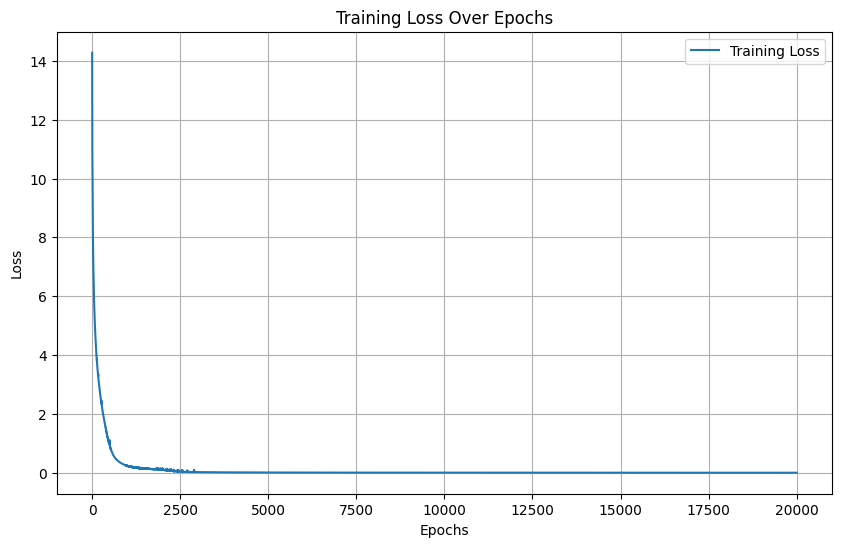

In [ ]:
train(x,y,20000)

* The loss will come around 0.02 after 20000 epochs (again, it is absolutely fine if you get a different value)
* Let us predict the masked tokens for all the samples in the tiny dataset

In [ ]:
with torch.inference_mode():
  predictions = torch.argmax(model(x),dim=-1)

In [ ]:
v = Tk.build_vocab()
masked_words = []
predicted_words=[]
for index,idx in enumerate(y.flatten()):
  # to display only the masked tokens
  if idx != -100:
    masked_words.append(v.vocab.get_itos()[idx.item()])
    predicted_words.append(v.vocab.get_itos()[predictions.flatten()[index].item()])
print('Masked Words: ')
print(' '.join(masked_words))
print('Predicted Words: ')
print(' '.join(predicted_words))

Masked Words: 
he polymath his problem-solving . on hamming , decided . biography of few about facts and questions legacy legacy their the and . is containing of story particular recalled . unpublished photographs videos which me s legacy demonstrates , including pursuit continue to gift the
Predicted Words: 
he polymath his problem-solving . on hamming , decided . biography of few about facts and questions legacy legacy their the and . is containing of story particular recalled . unpublished photographs videos which me s legacy demonstrates , including pursuit continue to gift the
